In [1]:
import numpy as np
import pandas as pd
import os
import glob
from IPython.display import clear_output

results_dir = '../../params_results/*/*/*/*/summary.csv'
summary_files = glob.glob(results_dir)

In [50]:
res_df_list = [[], [], []]
failed_jobs = []
for i, s_file in enumerate(summary_files):
    clear_output()
    print('{}/{}'.format(i, len(summary_files)))
    s_params = s_file.split('\\')
    config_file = s_file.replace('summary.csv', 'config.csv')
    dist_type = s_params[1]
    exploration_strategy = s_params[2]
    hs_name = s_params[3]
    batch_size = s_params[4]
    
    hs_info = [dist_type, exploration_strategy, hs_name, batch_size, config_file]
    hs_id = '{}_{}_{}_{}'.format(dist_type, exploration_strategy, hs_name, batch_size)
    
    if pd.read_csv(config_file)['use_intra_cluster_threshold_for_exploration'][0] == False or pd.read_csv(config_file)['use_intra_cluster_threshold_for_exploitation'][0] == False:
        failed_jobs.append('{}_{}_{}'.format(dist_type, exploration_strategy, hs_name))
        continue
        
    df = pd.read_csv(s_file, index_col=0)
    bsize_df = df[['exploitation_batch_size', 'exploration_batch_size']]
    exploit_df = df[[m for m in df.columns if 'exploitation_hits_at_' in m]].sum(axis=1).to_frame(name='exploitation_hits')
    explore_df = df[[m for m in df.columns if 'exploration_hits_at_' in m]].sum(axis=1).to_frame(name='exploration_hits')
    exploit_max_df = df[[m for m in df.columns if 'exploitation_max_hits_at_' in m]].sum(axis=1).to_frame(name='exploitation_max_hits')
    explore_max_df = df[[m for m in df.columns if 'exploration_max_hits_at_' in m]].sum(axis=1).to_frame(name='exploration_max_hits')
    
    sum_df = pd.concat([bsize_df, exploit_df, exploit_max_df, explore_df, explore_max_df], axis=1)
    sum_df['total_batch_size'] = sum_df['exploitation_batch_size'] + sum_df['exploration_batch_size']
    sum_df['total_hits'] = sum_df['exploitation_hits'] + sum_df['exploration_hits']
    sum_df['total_max_hits'] = sum_df['exploitation_max_hits'] + sum_df['exploration_max_hits']
    sum_df['total_max_hits'] = sum_df['total_max_hits'].apply((lambda x: min(x, int(batch_size.split('_')[-1]))))
    
    sum_df.iloc[-1,:] = sum_df.iloc[:-1,:].sum(axis=0)
    sum_df['iteration'] = list(range(10)) + [9999]
    sum_df['hyperparameter_id'] = hs_id
    sum_df.index = list(range(10)) + ['total']
    
    sum_df['config_file'] = config_file
    
    if batch_size == 'batch_size_96':
        res_df_list[0].append(sum_df)
    elif batch_size == 'batch_size_384':
        res_df_list[1].append(sum_df)
    else:
        res_df_list[2].append(sum_df)

all_0 = pd.concat(res_df_list[0])
all_1 = pd.concat(res_df_list[1])
all_2 = pd.concat(res_df_list[2])
all_0['hits_to_batch_size_ratio'] = all_0['total_hits'] / all_0['total_batch_size']
all_1['hits_to_batch_size_ratio'] = all_1['total_hits'] / all_1['total_batch_size']
all_2['hits_to_batch_size_ratio'] = all_2['total_hits'] / all_2['total_batch_size']
failed_jobs = list(np.unique(failed_jobs))

2315/2316


In [3]:
print('Successfull hs: {}'.format(len(all_0['hyperparameter_id'].unique())))
print('Failed hs: {}'.format(len(failed_jobs)))
print('Total hs: {}'.format(len(all_0['hyperparameter_id'].unique()) + len(failed_jobs)))

Successfull hs: 164
Failed hs: 789
Total hs: 953


---
# Plots

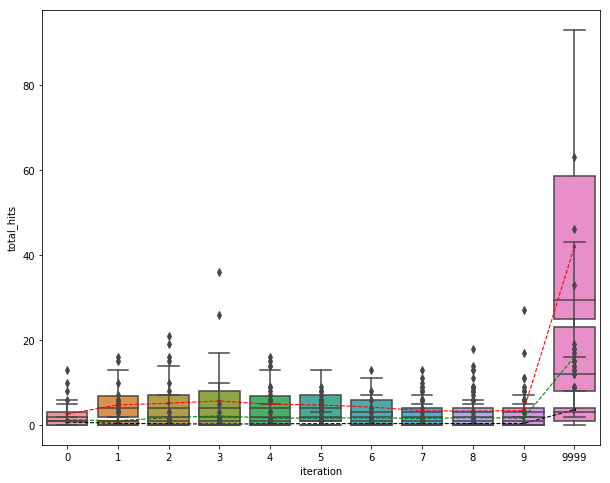

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.boxplot(x="iteration", y="total_hits", data=all_0)
sns.pointplot(x="iteration", y="total_hits", data=all_0, linestyles='--', scale=0.4, 
              color='k', errwidth=0, capsize=0)

sns.boxplot(x="iteration", y="total_hits", data=all_1)
sns.pointplot(x="iteration", y="total_hits", data=all_1, linestyles='--', scale=0.4, 
              color='g', errwidth=0, capsize=0)

sns.boxplot(x="iteration", y="total_hits", data=all_2)
sns.pointplot(x="iteration", y="total_hits", data=all_2, linestyles='--', scale=0.4, 
              color='r', errwidth=0, capsize=0)

plt.show()

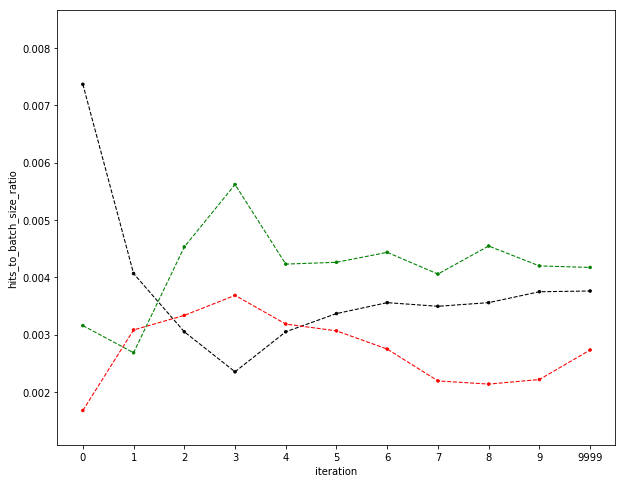

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
#sns.boxplot(x="iteration", y="hits_to_batch_size_ratio", data=all_0)
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", data=all_0, linestyles='--', scale=0.4, 
              color='k', errwidth=0, capsize=0)

#sns.boxplot(x="iteration", y="hits_to_batch_size_ratio", data=all_1)
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", data=all_1, linestyles='--', scale=0.4, 
              color='g', errwidth=0, capsize=0)

#sns.boxplot(x="iteration", y="hits_to_batch_size_ratio", data=all_2)
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", data=all_2, linestyles='--', scale=0.4, 
              color='r', errwidth=0, capsize=0)

plt.show()

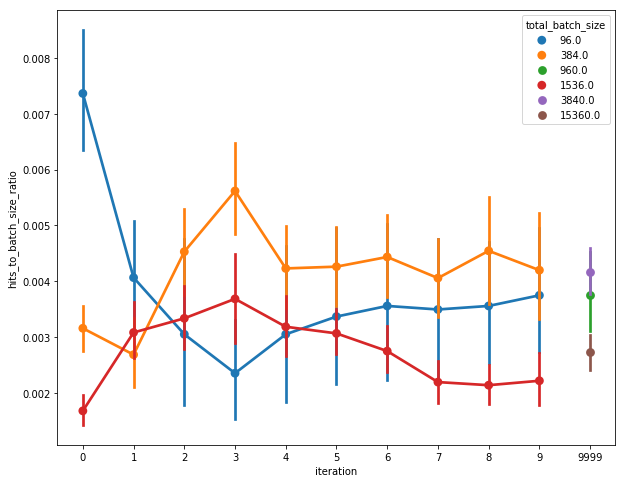

In [6]:
all_df = pd.concat([all_0, all_1, all_2])
plt.figure(figsize=(10, 8))
#sns.boxplot(x="iteration", y="hits_to_batch_size_ratio", data=all_0)
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", hue="total_batch_size", data=all_df)
plt.show()

In [62]:
top_hs = all_0[all_0['iteration'] == 9999].sort_values('total_hits')
top_hs = top_hs[top_hs['total_hits'] >= np.quantile(top_hs['total_hits'], 0.8)]

In [63]:
top_hs

,exploitation_batch_size,exploration_batch_size,exploitation_hits,exploitation_max_hits,exploration_hits,exploration_max_hits,total_batch_size,total_hits,total_max_hits,iteration,hyperparameter_id,config_file,hits_to_batch_size_ratio
total,470.0,490.0,3.0,470.0,2.0,490.0,960.0,5.0,960.0,9999,distributive_dissimilar_ClusterBasedWCSelector...,../../params_results\distributive\dissimilar\C...,0.005208
total,0.0,960.0,0.0,0.0,5.0,960.0,960.0,5.0,960.0,9999,distributive_weighted_ClusterBasedWCSelector_2...,../../params_results\distributive\weighted\Clu...,0.005208
total,469.0,491.0,3.0,469.0,2.0,491.0,960.0,5.0,960.0,9999,distributive_dissimilar_ClusterBasedWCSelector...,../../params_results\distributive\dissimilar\C...,0.005208
total,480.0,480.0,5.0,480.0,0.0,480.0,960.0,5.0,960.0,9999,random_random_ClusterBasedWCSelector_115_batch...,../../params_results\random\random\ClusterBase...,0.005208
total,0.0,960.0,0.0,0.0,5.0,960.0,960.0,5.0,960.0,9999,distributive_weighted_ClusterBasedWCSelector_5...,../../params_results\distributive\weighted\Clu...,0.005208
total,457.0,503.0,2.0,457.0,3.0,503.0,960.0,5.0,960.0,9999,distributive_weighted_ClusterBasedWCSelector_3...,../../params_results\distributive\weighted\Clu...,0.005208
total,950.0,10.0,3.0,950.0,2.0,10.0,960.0,5.0,960.0,9999,random_weighted_ClusterBasedWCSelector_79_batc...,../../params_results\random\weighted\ClusterBa...,0.005208
total,450.0,510.0,3.0,450.0,2.0,510.0,960.0,5.0,960.0,9999,random_weighted_ClusterBasedWCSelector_13_batc...,../../params_results\random\weighted\ClusterBa...,0.005208
total,461.0,499.0,1.0,461.0,4.0,499.0,960.0,5.0,960.0,9999,distributive_weighted_ClusterBasedWCSelector_4...,../../params_results\distributive\weighted\Clu...,0.005208
total,0.0,960.0,0.0,0.0,6.0,960.0,960.0,6.0,960.0,9999,distributive_weighted_ClusterBasedWCSelector_6...,../../params_results\distributive\weighted\Clu...,0.006250


---
# In-Depth

In [11]:
all_1[all_1['iteration'] == 9999].sort_values('total_hits')

,exploitation_batch_size,exploration_batch_size,exploitation_hits,exploitation_max_hits,exploration_hits,exploration_max_hits,total_batch_size,total_hits,total_max_hits,iteration,hyperparameter_id,hits_to_batch_size_ratio
total,0.0,3840.0,0.0,0.0,2.0,1314.0,3840.0,2.0,1314.0,9999,distributive_random_ClusterBasedWCSelector_782...,0.000521
total,0.0,3840.0,0.0,0.0,3.0,1313.0,3840.0,3.0,1313.0,9999,distributive_random_ClusterBasedWCSelector_732...,0.000781
total,0.0,3840.0,0.0,0.0,3.0,1305.0,3840.0,3.0,1305.0,9999,random_random_ClusterBasedWCSelector_126_batch...,0.000781
total,1885.0,1955.0,1.0,1312.0,2.0,1312.0,3840.0,3.0,2624.0,9999,distributive_dissimilar_ClusterBasedWCSelector...,0.000781
total,0.0,3840.0,0.0,0.0,3.0,1309.0,3840.0,3.0,1309.0,9999,distributive_random_ClusterBasedWCSelector_757...,0.000781
total,1907.0,1933.0,3.0,1306.0,0.0,1306.0,3840.0,3.0,2612.0,9999,random_random_ClusterBasedWCSelector_118_batch...,0.000781
total,0.0,3840.0,0.0,0.0,3.0,1311.0,3840.0,3.0,1311.0,9999,distributive_weighted_ClusterBasedWCSelector_5...,0.000781
total,0.0,3840.0,0.0,0.0,3.0,1313.0,3840.0,3.0,1313.0,9999,distributive_random_ClusterBasedWCSelector_700...,0.000781
total,0.0,3840.0,0.0,0.0,4.0,1304.0,3840.0,4.0,1304.0,9999,random_random_ClusterBasedWCSelector_101_batch...,0.001042
total,0.0,3840.0,0.0,0.0,4.0,1311.0,3840.0,4.0,1311.0,9999,random_random_ClusterBasedWCSelector_104_batch...,0.001042


In [36]:
all_2[all_2['iteration'] == -1].sort_values('total_hits').iloc[-1,8]

'random_weighted_ClusterBasedWCSelector_86_batch_size_1536'

In [24]:
all_0[all_0['hyperparameter_id'].str.contains('distributive_dissimilar_ClusterBasedWCSelector_892_batch_size_96')]

,exploitation_batch_size,exploration_batch_size,exploitation_hits,exploration_hits,total_batch_size,total_hits,total_max_hits,iteration,hyperparameter_id
0,17.0,79.0,1.0,0.0,96.0,1.0,17.0,0,distributive_dissimilar_ClusterBasedWCSelector...
1,47.0,49.0,0.0,0.0,96.0,0.0,47.0,1,distributive_dissimilar_ClusterBasedWCSelector...
2,47.0,49.0,0.0,0.0,96.0,0.0,47.0,2,distributive_dissimilar_ClusterBasedWCSelector...
3,47.0,49.0,1.0,0.0,96.0,1.0,47.0,3,distributive_dissimilar_ClusterBasedWCSelector...
4,47.0,49.0,2.0,0.0,96.0,2.0,47.0,4,distributive_dissimilar_ClusterBasedWCSelector...
5,47.0,49.0,3.0,0.0,96.0,3.0,47.0,5,distributive_dissimilar_ClusterBasedWCSelector...
6,17.0,79.0,2.0,0.0,96.0,2.0,17.0,6,distributive_dissimilar_ClusterBasedWCSelector...
7,24.0,72.0,1.0,0.0,96.0,1.0,24.0,7,distributive_dissimilar_ClusterBasedWCSelector...
8,21.0,75.0,2.0,0.0,96.0,2.0,21.0,8,distributive_dissimilar_ClusterBasedWCSelector...
9,21.0,75.0,0.0,0.0,96.0,0.0,21.0,9,distributive_dissimilar_ClusterBasedWCSelector...
